In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  # Handle any runtime initialization errors

2024-10-24 10:11:52.124670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 10:11:52.159421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 10:11:52.165925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 10:11:52.183590: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 10:11:58.250427: W tensorflow/compiler/tf2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import jax
from jax import numpy as jnp
from pathlib import Path
import tensorflow_probability as tfp

In [8]:
experiment_folder = 'ising_hightemp/dlmc_sweep'

directory = Path(f'{experiment_folder}')
dfs= []
for folder in directory.iterdir():
    if folder.is_dir():
        try:
            experiment_name = str(folder)[len(experiment_folder)+1:]
            if experiment_name[0] != '.':
                df = pd.read_csv(f'{experiment_folder}/{experiment_name}/results.csv')
                df['experiment'] = experiment_name
                dfs.append(df)
        except:
            print(f'Error loading {experiment_name}')
df = pd.concat(dfs)

In [36]:
df['ESS'] = df['ESS'].apply(
    lambda x: list(map(float, x.replace('[', '').replace(']', '').split()))
)

In [37]:
df['ESS'], df['ESS_std'] = df['ESS'].apply(lambda x: x[0]), df['ESS'].apply(lambda x: x[1])

In [43]:
ess_df = df[['Time','experiment','ESS','ESS_std']].copy().reset_index(drop=True).rename({'Time':'time'},axis=1)

In [55]:
import re

def extract_temp(string):
    # Use regular expression to find a number inside parentheses
    match = re.search(r'sampling_(\d+\.\d+).*', string)
    if match:
        return float(match.group(1))  # Return the number as an integer
    else:
        return None  # Return None if no match is found

def extract_replica_info(string):
    match = re.search(r'sampling_\d+\.\d+_re(\d+)_(\d+\.\d+)x', string)
    if match:
        return int(match.group(1)), float(match.group(2))  # Return the number as an integer
    else:
        return 1, 1  # Return None if no match is found

In [88]:
ess_df['temperature'] = ess_df['experiment'].apply(extract_temp)
ess_df['num_replicas'] = ess_df['experiment'].apply(lambda x: extract_replica_info(x)[0])
ess_df['temp_mult'] = ess_df['experiment'].apply(lambda x: extract_replica_info(x)[1])
ess_df['beta'] = 1/ess_df['temperature']

<Axes: xlabel='beta', ylabel='ESS'>

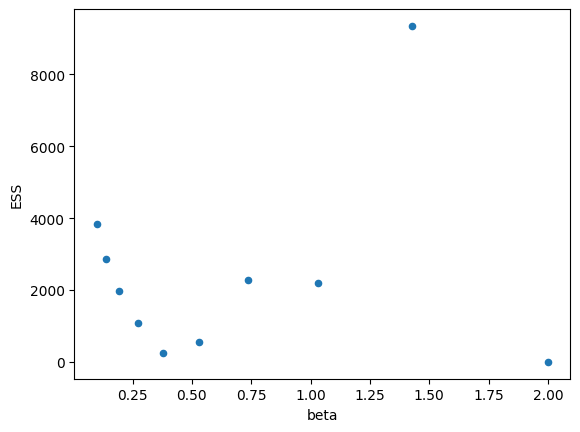

In [90]:
ess_df.query('num_replicas==1').plot(kind='scatter',x='beta',y='ESS')

In [93]:
ess_df.query('num_replicas==1').sort_values('temperature')

,time,experiment,ESS,ESS_std,temperature,num_replicas,temp_mult,beta
9,6.594950,sampling_0.50,1.00000,1.107107e-07,0.50,1,1.0,2.000000
59,6.590875,sampling_0.70,9347.14100,1.684852e+04,0.70,1,1.0,1.428571
98,6.735561,sampling_0.97,2187.70480,1.654861e+03,0.97,1,1.0,1.030928
99,6.671940,sampling_1.36,2266.78200,1.495482e+03,1.36,1,1.0,0.735294
107,6.367550,sampling_1.89,567.34400,3.699581e+02,1.89,1,1.0,0.529101
76,6.498480,sampling_2.64,239.37076,6.025043e+01,2.64,1,1.0,0.378788
3,6.556866,sampling_3.68,1086.38640,1.218751e+02,3.68,1,1.0,0.271739
105,6.769505,sampling_5.14,1978.94670,1.928567e+02,5.14,1,1.0,0.194553
64,6.741179,sampling_7.17,2871.37380,2.273407e+02,7.17,1,1.0,0.139470
84,6.561575,sampling_10.00,3837.67380,2.111715e+02,10.00,1,1.0,0.100000


In [147]:
ess_df.query('temperature==0.70').sort_values('temp_mult')

,time,experiment,ESS,ESS_std,temperature,num_replicas,temp_mult,beta
59,6.590875,sampling_0.70,9347.1410,16848.516,0.7,1,1.00,1.428571
39,106.609910,sampling_0.70_re10_2.00x,47469.3440,10870.462,0.7,10,2.00,1.428571
36,103.907345,sampling_0.70_re10_2.39x,47584.2030,10530.218,0.7,10,2.39,1.428571
38,107.470390,sampling_0.70_re10_2.86x,18022.3140,23467.723,0.7,10,2.86,1.428571
40,104.533442,sampling_0.70_re10_3.42x,5453.0986,14850.293,0.7,10,3.42,1.428571
48,104.169505,sampling_0.70_re10_4.09x,2948.4666,10797.610,0.7,10,4.09,1.428571
5,105.034417,sampling_0.70_re10_4.89x,2494.8882,8214.237,0.7,10,4.89,1.428571
79,107.566150,sampling_0.70_re10_5.85x,14803.5850,21216.281,0.7,10,5.85,1.428571
68,108.620579,sampling_0.70_re10_6.99x,15692.4320,21704.494,0.7,10,6.99,1.428571
80,104.973592,sampling_0.70_re10_8.36x,2985.9731,10788.747,0.7,10,8.36,1.428571


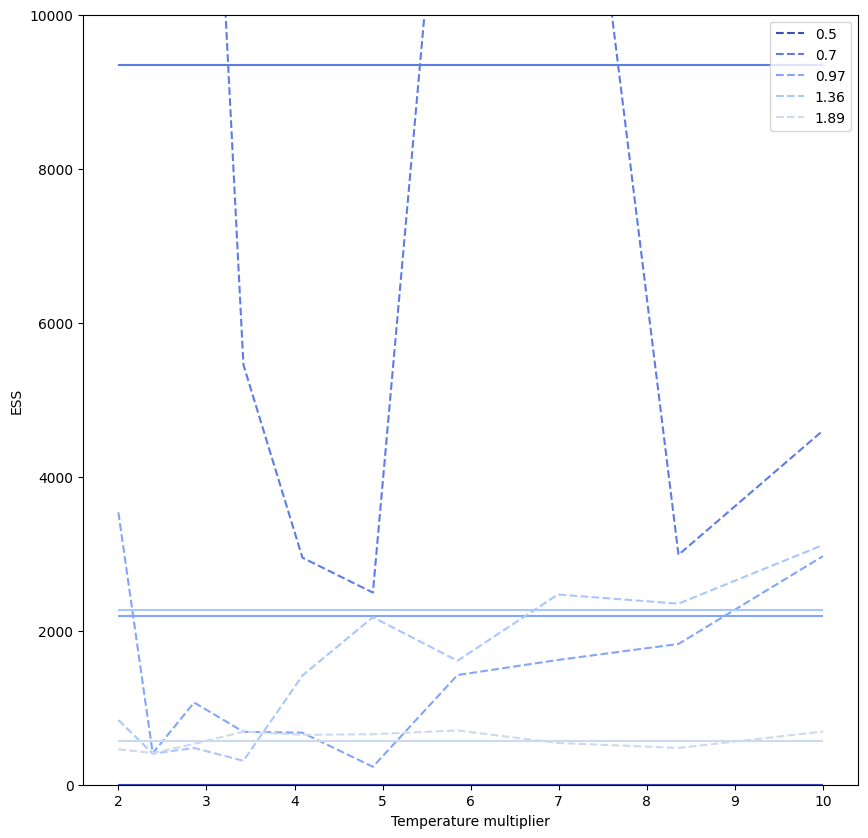

In [84]:
fig, ax = plt.subplots(figsize=(10,10))

pivot_df = ess_df.sort_values(['temperature','temp_mult']).pivot(values='ESS',index='temperature',columns='temp_mult')

num_colors = pivot_df.shape[0]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
for i in range(5):
    ax.hlines(pivot_df.iloc[i,0],pivot_df.columns[1],pivot_df.columns[-1], color = colors[i])
    ax.plot(pivot_df.iloc[i,1:], color = colors[i],label=pivot_df.index[i],ls='--')

ax.set_xlabel('Temperature multiplier')
ax.set_ylabel('ESS')

#ax.set_yscale('log')
ax.set_ylim(0,10e3)
ax.legend()


In [ ]:
experiment_folder = 'ising_hightemp/dlmc_test'
experiment_name = 'sampling'

In [154]:
with open(f'{experiment_folder}/{experiment_name}/samples.pkl', 'rb') as file:
    samples = pickle.load(file)
with open(f'{experiment_folder}/{experiment_name}/params.pkl', 'rb') as file:
    params = pickle.load(file) 

In [155]:
params = params['params']

In [156]:
params.shape

(3, 3, 3)

In [157]:
params

Array([[[-0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5]],

       [[-0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5]],

       [[-0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ]]], dtype=float32)

In [148]:
experiment_folder = 'ising_hightemp/dlmc_sweep'
experiment_name = 'sampling_2.64'
with open(f'{experiment_folder}/{experiment_name}/energies.pkl', 'rb') as file:
    # Load the object from the file
    energies=pickle.load(file)

energies = energies['array']

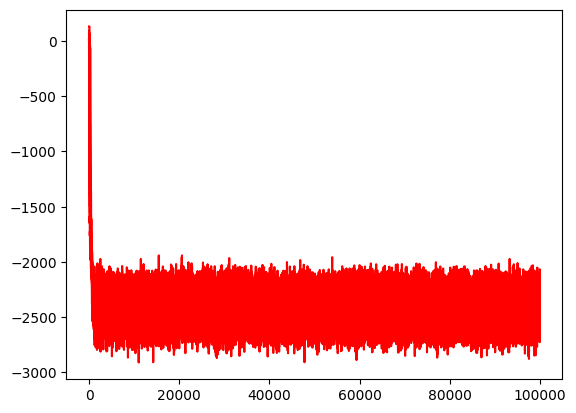

In [137]:
_ = plt.plot(energies*2.64,color='red')

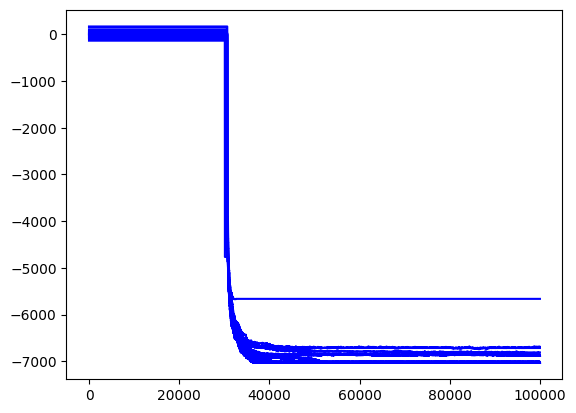

In [132]:
_ = plt.plot(energies,color='blue')

In [130]:
energies

Array([[  100.36197 ,    22.939878,   -86.02454 , ...,   169.18161 ,
          -28.674849,   -48.747242],
       [  100.36197 ,    22.939878,   -86.02454 , ...,   169.18161 ,
          -28.674849,   -48.747242],
       [  100.36197 ,    22.939878,   -86.02454 , ...,   169.18161 ,
          -28.674849,   -48.747242],
       ...,
       [-7025.338   , -6692.7095  , -6864.759   , ..., -7025.338   ,
        -7025.338   , -7025.338   ],
       [-7025.338   , -6692.7095  , -6864.759   , ..., -7025.338   ,
        -7025.338   , -7025.338   ],
       [-7025.338   , -6692.7095  , -6864.759   , ..., -7025.338   ,
        -7025.338   , -7025.338   ]], dtype=float32)

In [182]:
experiment_folder = 'ising_hightemp/dlmc_test'
experiment_name = 'sampling_re'
with open(f'{experiment_folder}/{experiment_name}/energies.pkl', 'rb') as file:
    # Load the object from the file
    energies=pickle.load(file)

energies = energies['array']

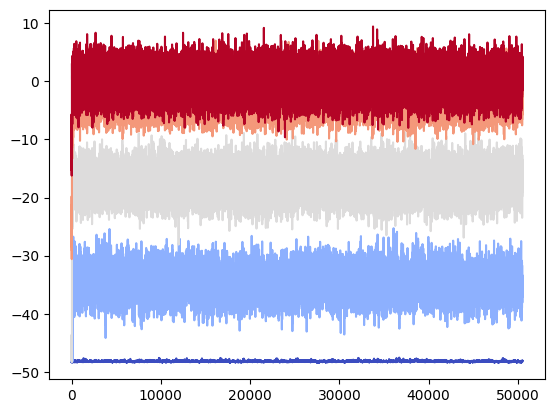

In [183]:
num_colors = energies.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
for i in range(num_colors):
    plt.plot(energies.mean(axis=2)[:,i], color = colors[i])

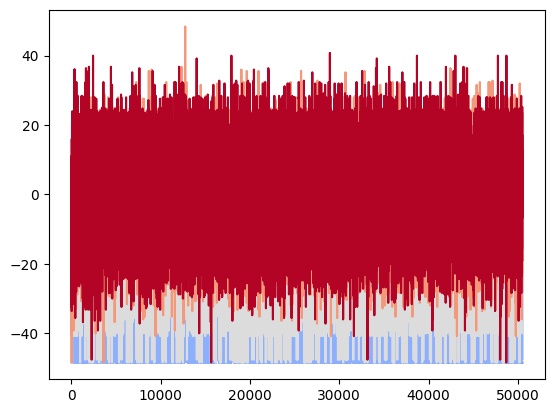

In [184]:
num_colors = energies.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
for i in range(num_colors):
    plt.plot(energies[:,i,0], color = colors[i])

In [72]:
experiment_folder = 'ising_hightemp/dlmc_4x4_0.9'
experiment_name = 'sampling_re_5'

with open(f'{experiment_folder}/{experiment_name}/swap_probs.pkl', 'rb') as file:
    # Load the object from the file
    swap_probs=pickle.load(file)

swap_probs = swap_probs['array']

num_colors = swap_probs.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
n = 1000
for i in range(num_colors):
    plt.plot(np.cumsum(swap_probs[n:,i,0])/(n+1+np.arange(swap_probs.shape[0]-n)), color = colors[i])
    
plt.hlines(0.2,0,swap_probs.shape[0]-n,color='black',lw=3)

FileNotFoundError: [Errno 2] No such file or directory: 'ising_hightemp/dlmc_4x4_0.9/sampling_re_5/swap_probs.pkl'

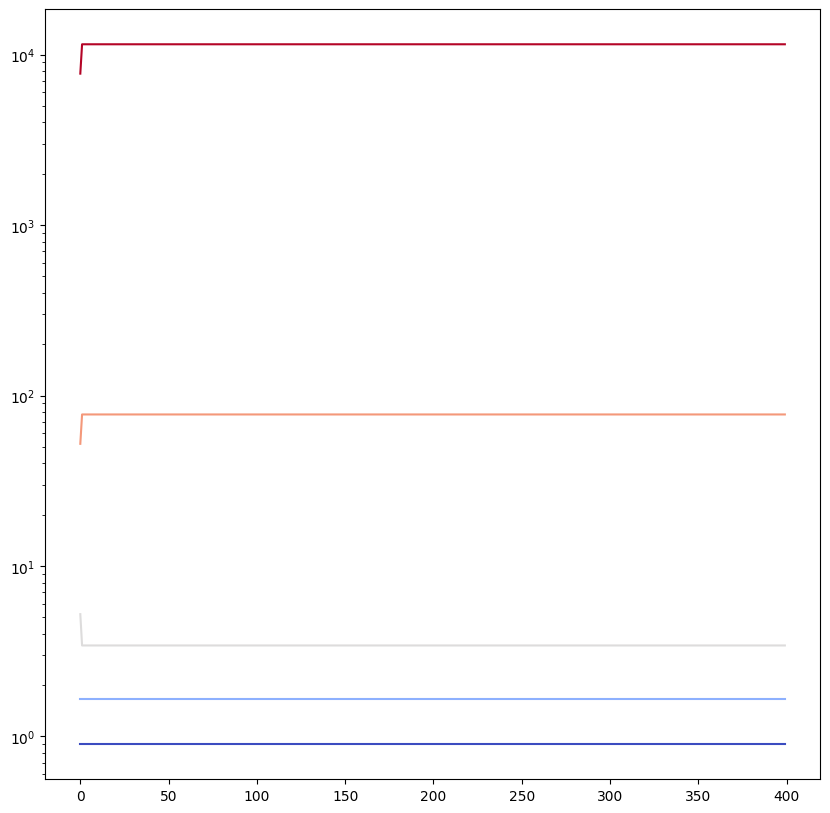

In [75]:
experiment_folder = 'ising_hightemp/dlmc_4x4_0.9'
experiment_name = 'sampling_re_5'

with open(f'{experiment_folder}/{experiment_name}/temps.pkl', 'rb') as file:
    # Load the object from the file
    temps=pickle.load(file)

temps = temps['array']
fig, ax = plt.subplots(figsize=(10,10))
num_colors = temps.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
for i in range(num_colors):
    ax.plot(temps[:,i,0], color = colors[i])

#ax.set_ylim(0.05,1)
ax.set_yscale('log')

## Exact computation

In [4]:
import os
os.chdir('discs-thesis/discs/results')

FileNotFoundError: [Errno 2] No such file or directory: 'discs-thesis/discs/results'

In [6]:
!pwd

/home/lclaeys/discs-thesis/discs/results


In [20]:
import yaml
import types
from discs.models.ising import Ising

In [21]:
experiment_folder = 'ising_hightemp/dlmc_4x4_0.9'
experiment_name = 'sampling'

In [22]:
with open(f'{experiment_folder}/{experiment_name}/params.pkl', 'rb') as file:
    # Load the object from the file
    params=pickle.load(file)

In [23]:
with open(f'{experiment_folder}/{experiment_name}/config.yaml', 'rb') as file:
    # Load the object from the file
    config=yaml.load(file,Loader=yaml.UnsafeLoader)

In [24]:
model = Ising(config.model)

In [25]:
params['temperature'] = 0.9

In [26]:
params['params'] = params['params']*np.array([1,1,1])[:,None,None]

In [27]:
def temperature_forward(self, params, x):
    # Call the original forward method
    original_fwd = self._original_forward(params, x)
    # Multiply the result by the temperature
    return original_fwd / params['temperature']

model._original_forward = model.forward
model.forward = types.MethodType(temperature_forward, model)

In [28]:
def generate_ising_states(L=4):
    """
    Generate all possible spin configurations for a LxL Ising model.
    Each spin configuration is represented as a binary array and mapped to (-1, 1).
    """
    # Number of spins
    num_spins = L * L
    
    # Generate all possible binary configurations (0, 1) of length num_spins
    all_states = np.array(np.meshgrid(*[[0, 1]]*num_spins)).T.reshape(-1, num_spins)
    
    return all_states

In [29]:
all_states = jnp.array(generate_ising_states(L=4).reshape([-1,4,4]))

In [30]:
all_magnetizations = (2*all_states-1).sum(axis=[-1,-2])

In [31]:
all_states = jnp.array(all_states)

In [32]:
all_energies = -model.forward(params,all_states)

/home/lclaeys/miniconda3/envs/discs-env/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [33]:
all_likelihoods = jnp.exp(-all_energies)

In [34]:
p = all_likelihoods/all_likelihoods.sum()

In [35]:
expected_magnetization = (p*all_magnetizations).sum()
expected_magnetization

Array(14.941369, dtype=float32)

In [36]:
sigma_magnetization = np.sqrt((p*(all_magnetizations-expected_magnetization)**2).sum())

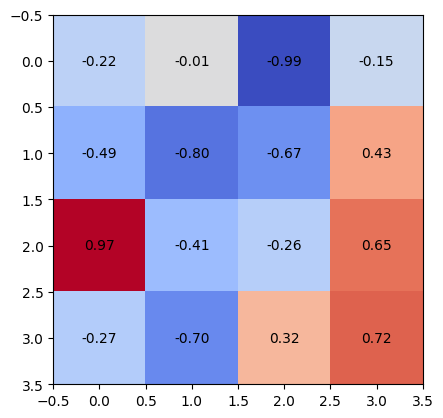

In [37]:
field = params['params'][2]

plt.imshow(field,cmap='coolwarm',interpolation=None)
for i in range(field.shape[0]):
    for j in range(field.shape[1]):
        plt.text(j, i, f'{field[i, j]:.2f}', ha="center", va="center", color="black")


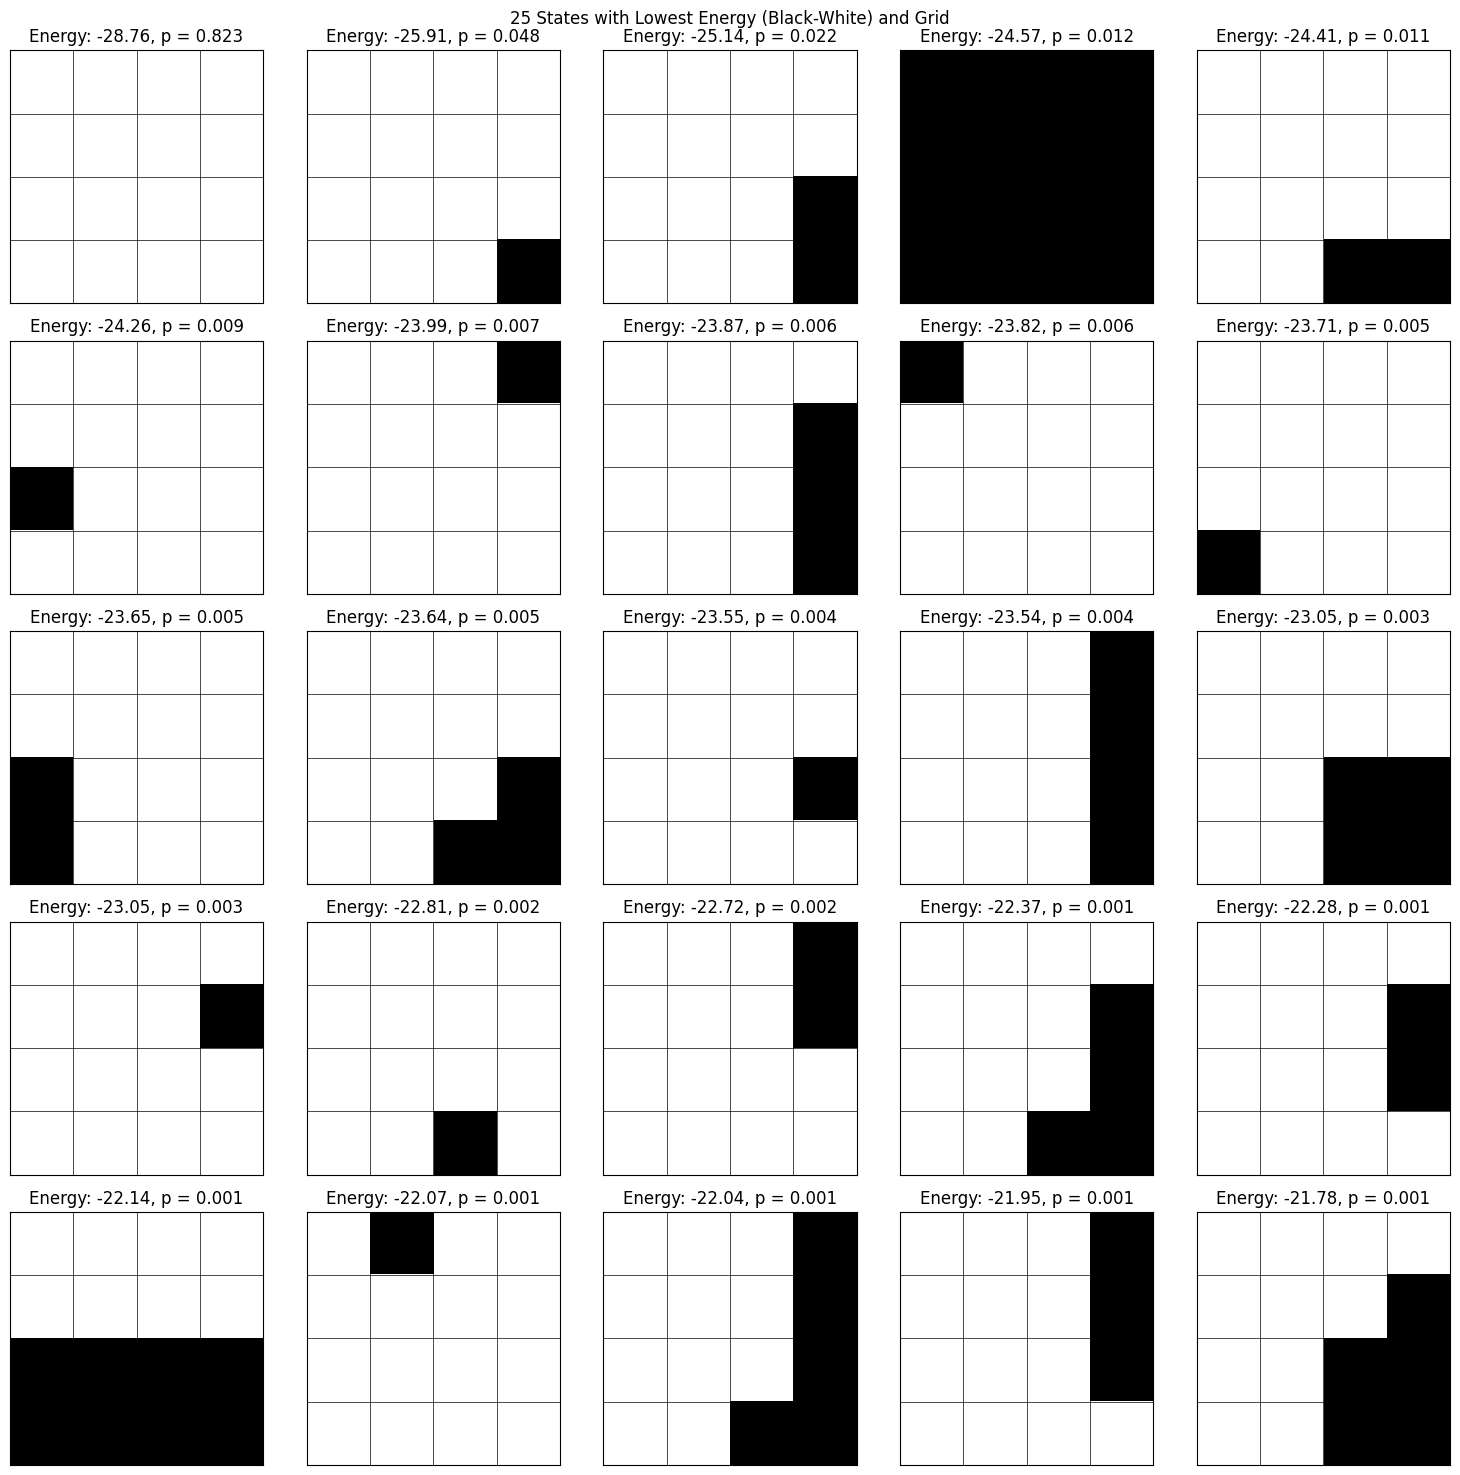

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_lowest_energy_states(all_states, all_energies, p, num_states=4):
    """
    Visualize the specified number of states (must be a square number) with the lowest energy values from the Ising model.
    
    Parameters:
    - all_states: 3D array of shape [num_configs, 4, 4], binary states (0s and 1s)
    - all_energies: 1D array of shape [num_configs], energies corresponding to each state
    - num_states: The number of states with the lowest energies to visualize (must be a perfect square)
    """
    # Ensure num_states is a perfect square
    n = int(np.sqrt(num_states))
    if n**2 != num_states:
        raise ValueError("num_states must be a perfect square.")
    
    # Find the indices of the lowest energies
    lowest_energy_indices = np.argsort(all_energies)[:num_states]

    # Extract the corresponding states and energy values
    lowest_states = all_states[lowest_energy_indices]
    lowest_energies = all_energies[lowest_energy_indices]
    lowest_p = p[lowest_energy_indices]

    # Plot the lowest energy states in a n x n grid with consistent coloring (0 -> white, 1 -> black)
    fig, axes = plt.subplots(n, n, figsize=(15,15))
    axes = axes.flatten()  # Flatten the axes array to iterate easily
    for i, ax in enumerate(axes):
        ax.imshow(lowest_states[i], cmap='gray', interpolation='none', vmin=0, vmax=1)  # Ensure consistent 0->white, 1->black
        ax.set_title(f"Energy: {lowest_energies[i]:.2f}, p = {lowest_p[i]:.3f}")
        
        # Add a grid by setting the ticks and displaying the grid lines
        ax.set_xticks(np.arange(-0.5, 4, 1))
        ax.set_yticks(np.arange(-0.5, 4, 1))
        ax.grid(True, color='black', linestyle='-', linewidth=0.5)  # Customize grid appearance
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide tick labels

    plt.suptitle(f'{num_states} States with Lowest Energy (Black-White) and Grid')
    plt.tight_layout()
    plt.show()

# Visualize the 4 (2x2) states with the lowest energy
visualize_lowest_energy_states(all_states, all_energies, p, num_states=25)

In [77]:
def plot_magnetization_estimation(experiment_names,agg=False,num_points=50,expected_magnetization=None):
    fig, ax = plt.subplots(1,len(experiment_names),figsize=(12,7),sharey=True)
    for i, experiment_name in enumerate(experiment_names):
        with open(f'{experiment_folder}/{experiment_name}/magnetizations.pkl', 'rb') as file:
            # Load the object from the file
            magnetization_estimates=pickle.load(file)['array']

        magnetization_estimates = jnp.reshape(magnetization_estimates,(magnetization_estimates.shape[0],magnetization_estimates.shape[-1]))
        
        print(magnetization_estimates.shape)
        multiplier = magnetization_estimates.shape[0]//num_points
        iterations = multiplier*np.arange(num_points)
        magnetization_estimates = magnetization_estimates[::multiplier,:]

        
        std_estimate = np.std(magnetization_estimates,axis=1)
        if agg:
            mean_estimate = magnetization_estimates.mean(axis=1)
            ax[i].plot(iterations,mean_estimate,color='grey',lw=2)
            ax[i].fill_between(iterations, 
                            mean_estimate - std_estimate, 
                            mean_estimate + std_estimate, 
                            alpha=0.3,color='grey')  # alpha for transparency
            
        else:
            ax[i].plot(iterations,magnetization_estimates,color='grey',alpha=min(1,15/magnetization_estimates.shape[1]),lw=.8)
        
        if expected_magnetization is not None:
            ax[i].hlines(expected_magnetization,0,multiplier*num_points,color='black',ls='-',label='true magnetization')
        ax[i].set_title(f'{experiment_name}')
        ax[i].legend()
        #ax[i].set_ylim(10,16)
        #ax[i].set_xscale('log')
        #ax[i].set_xlim(0,1e5)
        #x = np.arange(1,magnetization_estimates.shape[0])
        #ax[i].plot(x, expected_magnetization + sigma_magnetization/np.sqrt(x),color='black', lw=0.5, ls='--')


    plt.suptitle('Magnetization estimates')
    #plt.ylim(expected_magnetization-1,expected_magnetization+1)

(400, 100)
(400, 100)
(400, 100)


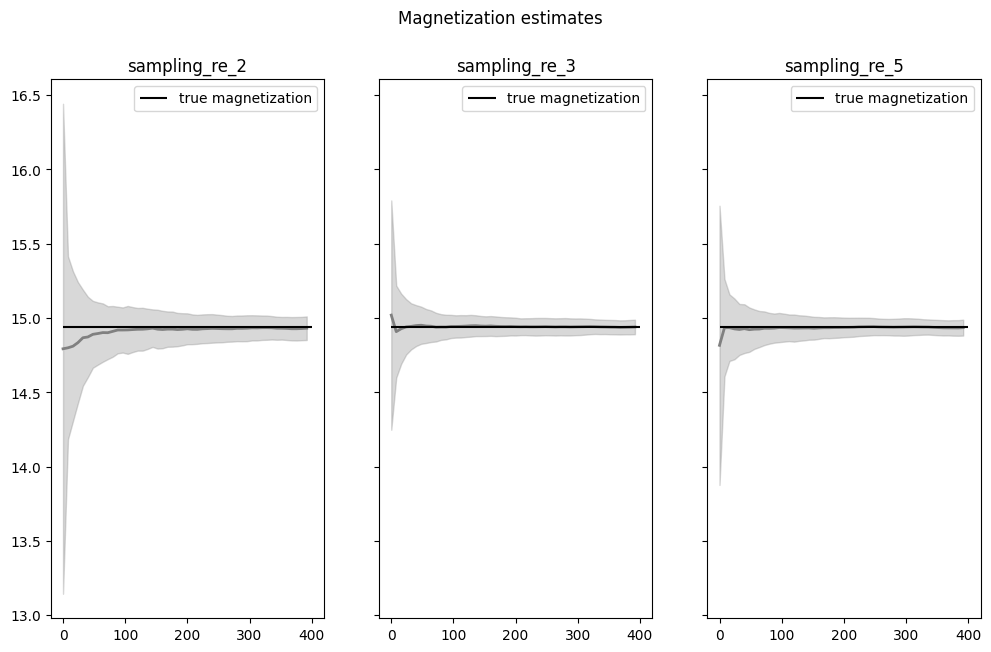

In [78]:
plot_magnetization_estimation(['sampling_re_2', 'sampling_re_3','sampling_re_5'],agg=True,expected_magnetization=expected_magnetization)

In [79]:
def plot_magnetization_estimation(experiment_names,agg=True,num_points=50):
    fig, ax = plt.subplots(figsize=(10,7))
    for i, experiment_name in enumerate(experiment_names):
        with open(f'{experiment_folder}/{experiment_name}/magnetizations.pkl', 'rb') as file:
            # Load the object from the file
            magnetization_estimates=pickle.load(file)['array']
        
        magnetization_estimates = jnp.reshape(magnetization_estimates,(magnetization_estimates.shape[0],magnetization_estimates.shape[-1]))

        multiplier = magnetization_estimates.shape[0]//num_points
        iterations = multiplier*np.arange(num_points)*1000
        magnetization_estimates = magnetization_estimates[::multiplier,:]
        
        mses = (magnetization_estimates-expected_magnetization)**2
        
        if agg:
            mean_mse = np.mean(mses,axis=1)
            std_mse = np.std(mses,axis=1)
            ax.plot(iterations,mean_mse,lw=2,label=experiment_name)
            ax.fill_between(iterations, 
                            mean_mse, 
                            mean_mse + std_mse, 
                            alpha=0.3)  # alpha for transparency
        else:
            ax.plot(mses[:,:10],color='grey',lw=.7,alpha=.8)
        
    x = np.arange(1,num_points*multiplier)*1000
    ax.plot(x, 1e2/x,color='black', lw=0.5, ls='-', label = '1e2/N')
    ax.plot(x, 1e3/x,color='black', lw=0.5, ls='-', label = '1e3/N')
    ax.plot(x, 1e4/x,color='black', lw=0.5, ls='-', label = '1e4/N')
    ax.plot(x, 1e5/x,color='black', lw=0.5, ls='-', label = '1e5/N')

    ax.set_ylim(1e-4,1e3)
    #ax.set_xlim(1e2,)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('iteration')
    ax.legend()

    plt.title('MSE of estimates')
    #plt.ylim(expected_magnetization-1,expected_magnetization+1)

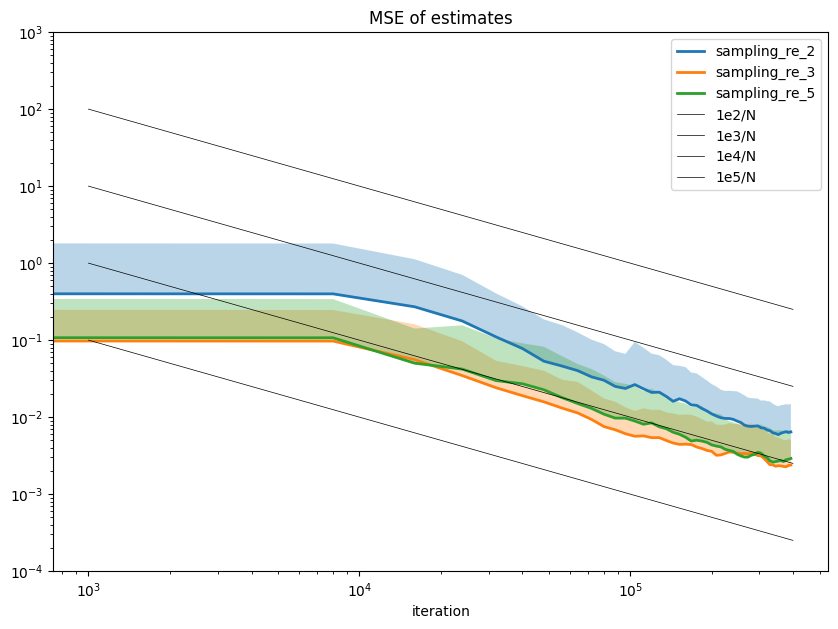

In [80]:
plot_magnetization_estimation(['sampling_re_2', 'sampling_re_3','sampling_re_5'],agg=True)

In [93]:
experiment_name = 'sampling_re_2'
with open(f'{experiment_folder}/{experiment_name}/magnetizations.pkl', 'rb') as file:
            # Load the object from the file
            magnetizations=pickle.load(file)['array']

In [94]:
magnetization_estimates = np.cumsum(magnetizations,axis=0)/(1+np.arange(magnetizations.shape[0])[:,None])

In [95]:
magnetization_estimates[-1].mean()

Array(14.3729, dtype=float32)

In [92]:
magnetization_estimates[-1].mean()

Array(14.623362, dtype=float32)

In [96]:
14.623362-14.3729

0.25046200000000063

In [392]:
with open(f'{experiment_folder}/{experiment_name}/samples.pkl', 'rb') as file:
    # Load the object from the file
    samples=pickle.load(file)

In [393]:
cpu_samples[1000:].sum(axis=2).shape

NameError: name 'cpu_samples' is not defined

In [231]:
with tf.device('/CPU:0'):
    ess = tfp.mcmc.effective_sample_size(cpu_samples[1000:].sum(axis=2),cross_chain_dims=1)
    ess2 = tfp.mcmc.effective_sample_size(cpu_samples[1000:].sum(axis=2))
    #no_cross_ess = tfp.mcmc.effective_sample_size(cpu_samples[1000:,0,:])

In [232]:
ess

<tf.Tensor: shape=(), dtype=float32, numpy=19.679306>

In [236]:
np.std(ess2)

8.396622

In [205]:
print(np.mean(ess/10))
np.mean(no_cross_ess)

nan


nan

In [190]:
print(np.std(ess/10))
np.std(no_cross_ess)

0.53716725


nan

In [13]:
1/(1+np.exp(-params['params']))

array([[0.37754068, 0.37754068, 0.37754068, ..., 0.37754068, 0.37754068,
        0.37754068],
       [0.37754068, 0.37754068, 0.37754068, ..., 0.37754068, 0.37754068,
        0.37754068],
       [0.37754068, 0.37754068, 0.37754068, ..., 0.37754068, 0.37754068,
        0.37754068],
       ...,
       [0.37754068, 0.37754068, 0.37754068, ..., 0.37754068, 0.37754068,
        0.37754068],
       [0.37754068, 0.37754068, 0.37754068, ..., 0.37754068, 0.37754068,
        0.37754068],
       [0.37754068, 0.37754068, 0.37754068, ..., 0.37754068, 0.37754068,
        0.37754068]], dtype=float32)

In [2]:
def plot_experiments(experiment_folders):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlabel('Iteration (adjusted)')  # Change this as appropriate
    ax.set_ylabel('Objective')
    ax.set_title('Objective with error bars (std)')
    
    for experiment_folder in experiment_folders:
        
        directory = Path(f'{experiment_folder}')
        results = {}
        for folder in directory.iterdir():
            if folder.is_dir():
                try:
                    experiment_name = str(folder)[len(experiment_folder)+1:]
                    if experiment_name[0] != '.':
                        with open(f'{experiment_folder}/{experiment_name}/results.pkl', 'rb') as file:
                            results[experiment_name] = pickle.load(file)
                except:
                    print(f'Error loading {experiment_name}')
        result_dfs = []
    
        for exp in results:
            df = pd.DataFrame({'mean_objective': np.mean(results[exp]['trajectory'],axis=1),
                               'std_objective': np.std(results[exp]['trajectory'],axis=1),
                               'experiment': f'{experiment_folder}: {exp}',
                               'running time': results[exp]['running_time']})
            result_dfs.append(df)
        
        df = pd.concat(result_dfs)

        mean_df = df.pivot(values='mean_objective',columns='experiment')
        std_df = df.pivot(values='std_objective',columns='experiment')
        
        # Loop through each column and plot the mean with the shaded area
        for column in mean_df.columns:
            number = extract_number(column) if extract_number(column) else 1
            #number = 1
            scaling = number*10
            ax.plot(mean_df.index*scaling, mean_df[column], label=column)
            ax.fill_between(mean_df.index*scaling, 
                            mean_df[column] - std_df[column], 
                            mean_df[column] + std_df[column], 
                            alpha=0.3)  # alpha for transparency
        
    # Adding labels, title, and legend
    #ax.set_xlim(0,5000)
    #ax.set_ylim(0,400)
    ax.grid()
    ax.legend()

    plt.show()
    #fig.savefig(experiment_folder+'/plot.png')

In [100]:
rng = jax.random.PRNGKey(0)

In [105]:
jax.random.permutation(rng,jnp.arange(1,2))

Array([1], dtype=int32)

In [49]:
jnp.arange(1,5)[1::2]

Array([2, 4], dtype=int32)

In [51]:
for i in range(0,5,2):
    print(i)

0
2
4


In [310]:
jnp.array([False, True]) & jnp.array([False, True])

Array([False,  True], dtype=bool)

In [311]:
np.exp(-5)

0.006737946999085467

In [2]:
import jax.numpy as jnp

In [4]:
jnp.repeat(jnp.array([1,2]),jnp.array([2,3]))

Array([1, 1, 2, 2, 2], dtype=int32)